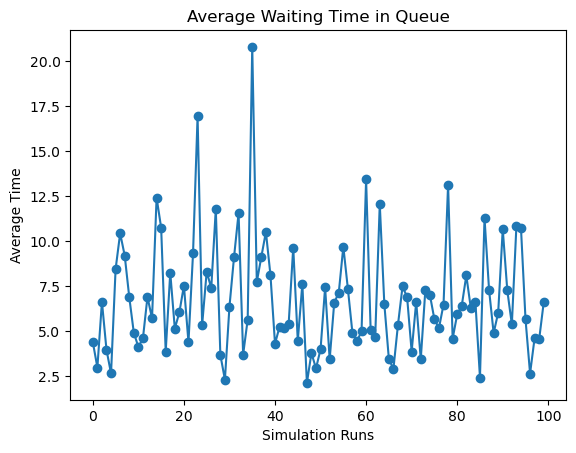

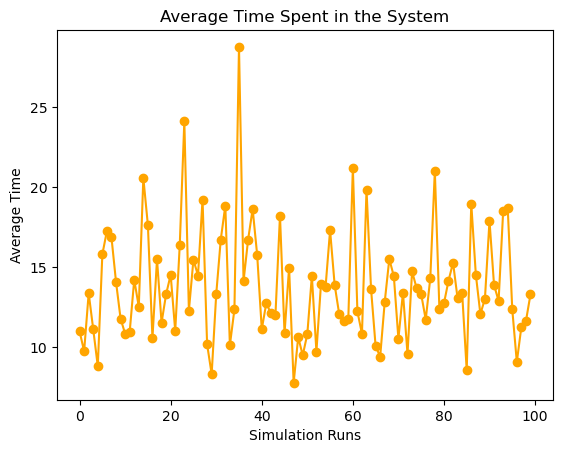

In [55]:
#M/M/3 model

import random
import simpy
import matplotlib.pyplot as plt

random_seed = 101
duration = 60*8
interarrival_time = 3
nurse_service_time = 1
doctor_service_time = [10,5,5]

#create a service process
class Patient():
    def __init__(self,env,patient_id, nurse_counter, doc_counters):
        self.env = env
        self.patient_id = patient_id
        self.nurse_counter = nurse_counter
        self.doc_counters = doc_counters
        env.process(self.service())
    
    def service(self):
        
        arrival_time = self.env.now
        
        #nursing service
        req = nurse_counter.request() 
        yield req
        waiting_time1 = self.env.now - arrival_time
        yield self.env.timeout(nurse_service_time)
        symptom = 'severe' if random.random() <= 0.2 else 'mild'
            
        #choose doctor service room
        if symptom == 'severe':
            choice = 0
        else:
            if doc_queues[1].size <= doc_queues[2].size:
                choice = 1
            else:
                choice = 2
            
        self.nurse_counter.release(req)
        finish_time1 = self.env.now
        
        doc_queues[choice].enqueue()

        #doctor service
        req2 = doc_counters[choice].request()
        yield req2
        waiting_time2 = self.env.now - finish_time1
        t = random.expovariate(1/doctor_service_time[choice])
        yield self.env.timeout(t)
        self.doc_counters[choice].release(req2)
        doc_queues[choice].dequeue()
        finish_time2 = self.env.now
        
        #for data analysis
        update_waiting_time(waiting_time1+waiting_time2)
        update_time_in_system(finish_time2 - arrival_time)

class queue():
    def __init__(self):
        self.size = 0
    
    def enqueue(self):
        self.size += 1
    
    def dequeue(self):
        if self.size != 0:
            self.size -= 1
                  
                
#create an arrival process
def patient_generator(env,nurse_couter, doc_counters):
    patient_id = 0
    Patient(env, patient_id, nurse_counter, doc_counters)
    while env.now < duration:
        patient_id += 1
        update_num_patients()
        t = random.expovariate(1/interarrival_time)
        yield env.timeout(t)
        Patient(env, patient_id, nurse_counter, doc_counters)


#for data analysis
def update_waiting_time(t):
    global total_waiting_time
    total_waiting_time += t

def update_time_in_system(t):
    global total_time_in_system
    total_time_in_system += t

def update_num_patients():
    global num_patients
    num_patients += 1
    

#main program 
random.seed(random_seed)

R = 100
X = range(0,R)
Y1 = []
Y2 = []

for i in X:
    
    total_waiting_time = 0
    total_time_in_system = 0
    num_patients = 0

    env=simpy.Environment()

    doc_counters = [simpy.Resource(env, capacity=1) for i in range(3)]
    
    doc_queues = [queue(),queue(),queue()] #for counting number of people in doctors' queues

    nurse_counter = simpy.Resource(env, capacity = 1)

    env.process(patient_generator(env,nurse_counter, doc_counters))

    env.run()
    
    Y1.append(total_waiting_time/num_patients)
    Y2.append(total_time_in_system/num_patients)
    
#Plotting graphs
plt.plot(X, Y1, "-o")
plt.title("Average Waiting Time in Queue")
plt.xlabel("Simulation Runs")
plt.ylabel("Average Time")
plt.show()

plt.plot(X, Y2, "-o", color= "orange")
plt.title("Average Time Spent in the System")
plt.xlabel("Simulation Runs")
plt.ylabel("Average Time")
plt.show()



In [56]:
import numpy as np
from scipy.stats import t

print(f"Expected average time in the system: {np.mean(Y1):.2f}")
print(f"Expected average time in queue: {np.mean(Y2):.2f}")

def confidence_interval(L, confidence):
    
    mean = np.mean(L)
    std = np.std(L)
    dof = len(L) - 1
    
    critical_t = np.abs(t.ppf((1-confidence)/2,dof))
    
    ci_value1 = round(mean - (std*critical_t)/np.sqrt(len(L)),2)
    ci_value2 = round(mean + (std*critical_t)/np.sqrt(len(L)),2)
    
    return ci_value1,ci_value2

print(f"Confidence interval of expected average time in the system: {confidence_interval(Y1, 0.95)}")
print(f"Confidence interval of expected average time in queue: {confidence_interval(Y2, 0.95)}")

Expected average time in the system: 6.73
Expected average time in queue: 13.78
Confidence interval of expected average time in the system: (6.11, 7.36)
Confidence interval of expected average time in queue: (13.08, 14.48)
